In [74]:
import numpy as np
import pandas as pd

from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

import lightgbm as lgbm

from IPython.display import display

In [2]:
df = pd.read_csv('data/train_final.csv', index_col='Id')
df_ult = pd.read_csv('data/test_final.csv', index_col='Id')

X = df.drop('Y', axis='columns').values
y = df['Y'].values

X_ult = df_ult.values

scale_pos_weight = len(y[y == 0])/len(y[y == 1])

In [59]:
def get_ind(mask): return [index for index, mask_ele in enumerate(mask) if mask_ele==True]

def get_best_ind(importances, start=7, number=5):
    ranked_features = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
    return [ranked_features[:i] for i in range(start, start + number)]

def get_best_features(model, data, step=1):
    rfecv = RFECV(estimator=model, step=step, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
    return rfecv.fit(data, y)

def get_clf():
    return lgbm.LGBMClassifier(n_estimators=500,
                               learning_rate=0.1, 
                               boosting_type='goss', 
                               max_depth=5, 
                               num_leaves=33,
                               objective='binary', 
                               scale_pos_weight=scale_pos_weight)

In [ ]:
def alter_params(params, dec):
    new_params = {}
    new_params['n_estimators'] = [round(params['n_estimators'] + np.ceil(dec)), 
                                  round(params['n_estimators'] - np.ceil(dec))]
    new_params['learning_rate'] = [params['learning_rate'] + 0.001 * dec, 
                                   params['learning_rate'] - 0.001 * dec]
    new_params['n_estimators'] = [round(params['num_leaves'] + np.ceil(0.05 * dec)), 
                                  round(params['num_leaves'] - np.ceil(0.05 * dec))]
    new_params['reg_alpha'] = [params['reg_alpha'] * (1 + (0.02 * dec)), 
                               params['reg_alpha'] * (1 - (0.02 * dec))]
    new_params['reg_lambda'] = [params['reg_lambda'] + (0.05 * dec), 
                                params['reg_lambda'] - (0.05 * dec)]
    return new_params

start_var_param = [{
    'n_estimators':                  500,
    'learning_rate':                 0.1, 
    'num_leaves':                    33, 
    'reg_alpha':                     0.001, 
    'reg_lambda':                    1, 
}]

In [12]:
fix_param = {
    'boosting_type':                 'goss', 
    'max_depth':                     5, 
    'objective':                     'binary', 
    'scale_pos_weight':              scale_pos_weight,
    'n_jobs':                        -1
}

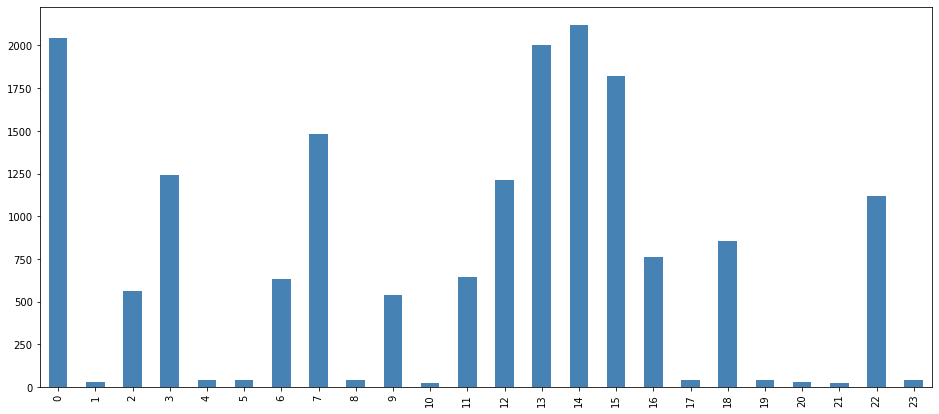

In [116]:
clf = clfs[2].fit(X, y)
pd.Series(clf.feature_importances_, index=list(range(X.shape[1]))).plot.bar(color='steelblue', figsize=(16, 7));

In [117]:
rankings = get_best_features(clfs[2], X).ranking_

print(get_ind(np.isin(rankings, [1])))
print(get_ind(np.isin(rankings, [1, 2, 3])))
print(get_ind(np.isin(rankings, [1, 2, 3, 4, 5])))

[0, 3, 7, 12, 13, 14, 15]
[0, 3, 7, 12, 13, 14, 15, 18, 22]
[0, 3, 7, 11, 12, 13, 14, 15, 16, 18, 22]


In [133]:
var_param = {'min_child_samples':             20,
             'learning_rate':                 0.1, 
             'num_leaves':                    31,
             'colsample_bytree':              1.0,
             'reg_alpha':                     0.000659,
             'reg_lambda':                    0.9}

def do_tune(tun_param, feats):
    grid = GridSearchCV(lgbm.LGBMClassifier(**fix_param, **var_param), 
                        tun_param, 
                        cv=StratifiedKFold(5), 
                        scoring='roc_auc', 
                        n_jobs=-1)
    
    grid.fit(X[:, feats], y)
    
    print(f'Best parameters {grid.best_params_}.')
    print(f'Best auc score is {grid.best_score_}.')
    
    clfs.append(grid.best_estimator_)

clfs = []
tun_param = [{'n_estimators':                  [910], # 895 to 915
              'min_child_weight':              [9e-7],
              'feature_fraction':              [0.25]}] #0.24 to 0.26
do_tune(tun_param, [3, 6, 7, 12, 13, 14, 15, 16, 18, 21])

tun_param = [{'n_estimators':                  [980], # 1000 to 970
              'min_child_weight':              [1e-7], 
              'feature_fraction':              [0.05]}] # 0.06 to 0.07
do_tune(tun_param, [0, 3, 7, 12, 13, 14, 15])

tun_param = [{'n_estimators':                  [845], # 844 to 847
              'min_child_weight':              [1e-7], 
              'feature_fraction':              [0.23],  # 0.2 to 0.25
              'seed':                          list(range(100))}]
do_tune(tun_param, [1, 3, 6, 7, 12, 13, 14, 15, 16, 18, 23])

tun_param = [{'n_estimators':                  [945], # 955 to 940
              'min_child_weight':              [1e-7], 
              'feature_fraction':              [0.38], # 0.41 to 0.35
              'seed':                          list(range(50, 100))}]
do_tune(tun_param, [0, 1, 3, 6, 7, 12, 13, 14, 15, 16, 18, 23])

tun_param = [{'n_estimators':                  [945], # 955 to 940
              'min_child_weight':              [1e-7], 
              'feature_fraction':              [0.38], # 0.41 to 0.35
              'seed':                          list(range(100, 150))}]
do_tune(tun_param, [0, 1, 3, 6, 7, 12, 13, 14, 15, 16, 18, 23])

Best parameters {'feature_fraction': 0.38, 'min_child_weight': 1e-07, 'n_estimators': 945, 'seed': 55}.
Best auc score is 0.8961743884754645.
Best parameters {'feature_fraction': 0.38, 'min_child_weight': 1e-07, 'n_estimators': 945, 'seed': 121}.
Best auc score is 0.8963934561372057.


In [134]:
req_rows = 16384
sealed_feats = []

display('Re-training...')
preds_dfs = []
for feats, clf in zip(sealed_feats, clfs):
    clf.fit(X[:, feats], y)
    preds_dfs.append(pd.DataFrame(clf.predict_proba(X_ult[:, feats])[:, 1], 
                          index=list(range(req_rows, req_rows*2 + 1)), 
                          columns=['Y']))

display('Writing...')
for idx, df in enumerate(preds_dfs):
    df.index.name = 'Id'
    df.to_csv(f'submission_26_{idx}.csv')
display('Done.')

'Re-training...'

'Writing...'

'Done.'